# 2d analytical case for testing wmb of tracer anomaly by transform


In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# =========================
# 1. Grid parameters
# =========================
Nx = 300           # Number of horizontal points
x_max = 3.0
x = np.linspace(0, x_max, Nx)

Nz = 50           # Number of vertical layers
z_max = 4000.0

# Non-uniform vertical grid (finer at surface, coarser at depth)
alpha = 3.0
eta = np.linspace(0, 1, Nz)
dz_cumulative = (np.exp(alpha*eta) - 1)/(np.exp(alpha) - 1) * z_max

# Layer center coordinates
z = np.zeros(Nz)
z[0] = 0.5 * dz_cumulative[0] + 3.0  # e.g., 1 m below surface
for k in range(1, Nz):
    z[k] = (dz_cumulative[k] + dz_cumulative[k-1])/2

# Time grid
dt = 0.025
t_max = 41
t = np.arange(1, t_max, dt)

# =========================
# 2. Meshgrid
# =========================
x2, z2, t2 = np.meshgrid(x, z, t, indexing='ij')  # Shape: (Nx, Nz, Nt)

# =========================
# 3. Horizontal temperature variations T_surface(x,t)
# =========================
k1 = 3*np.pi
k2 = 0.7*np.pi
T_surface = (8/np.pi*np.cos(np.pi*t2)
             + 3/np.pi*np.cos(np.pi*t2/3)
             + 2*np.sin(k1*(x2-t2))
             + 4*np.sin(k2*(x2-t2))
             + 15)

# =========================
# 4. Vertical structure f(z) with smooth mixed layer + thermocline
# =========================
h_m = 100.0    # Mixed layer depth (center of thermocline)
delta = 1000.0 # Thermocline thickness
f_z = 1. * (1 - np.tanh((z2 - h_m)/delta))  # Smooth decay from surface to deep

# Full 3D temperature field
T = T_surface * f_z

# =========================
# 5. Horizontal velocity u(z,t)
# =========================
u0 = 0.1      # Base velocity
eps = 0.5     # Relative amplitude of time oscillation
omega = 2*np.pi/30  # Oscillation period
H_u = 1000.0       # Vertical decay scale

g_z = np.exp(-z2/H_u)
u_zt = u0 * (1 + eps*np.sin(omega*t2)) * g_z

# =========================
# 6. Temperature derivatives Tt and Tx
# =========================
Tx = f_z * (2*k1*np.cos(k1*(x2-t2)) + 4*k2*np.cos(k2*(x2-t2)))
Tt = f_z * (-8*np.sin(np.pi*t2)
            -1*np.sin(np.pi*t2/3)
            -2*k1*np.cos(k1*(x2-t2))
            -4*k2*np.cos(k2*(x2-t2)))

# =========================
# 7. Advection term -u * Tx
# =========================
adv = - u_zt * Tx

# =========================
# 8. Forcing term Tdot = Tt + u*Tx
# =========================
Tdot = Tt + u_zt * Tx

# =========================
# 9. Create xarray DataArrays
# =========================
T_da = xr.DataArray(T, dims=['x','z','t'], coords={'x':x,'z':z,'t':t}, name='T')
Tdot_da = xr.DataArray(Tdot, dims=['x','z','t'], coords={'x':x,'z':z,'t':t}, name='Tdot')
adv_da = xr.DataArray(adv, dims=['x','z','t'], coords={'x':x,'z':z,'t':t}, name='Adv')
u_da = xr.DataArray(u_zt, dims=['x','z','t'], coords={'x':x,'z':z,'t':t}, name='u')
Tt_da = xr.DataArray(Tt, dims=['x','z','t'], coords={'x':x,'z':z,'t':t}, name='Tt')
Tx_da = xr.DataArray(Tx, dims=['x','z','t'], coords={'x':x,'z':z,'t':t}, name='Tx')


T_da = T_da.transpose('t', 'x', 'z')
Tdot_da = Tdot_da.transpose('t', 'x', 'z')
adv_da = adv_da.transpose('t', 'x', 'z')
u_da = u_da.transpose('t', 'x', 'z')
Tt_da = Tt_da.transpose('t', 'x', 'z')
Tx_da = Tx_da.transpose('t', 'x', 'z')



array([3.00000000e+00, 6.61627191e+00, 2.02665509e+01, 3.47786752e+01,
       5.02070594e+01, 6.66095539e+01, 8.40476619e+01, 1.02586769e+02,
       1.22296390e+02, 1.43250429e+02, 1.65527454e+02, 1.89210996e+02,
       2.14389858e+02, 2.41158453e+02, 2.69617151e+02, 2.99872661e+02,
       3.32038430e+02, 3.66235068e+02, 4.02590797e+02, 4.41241937e+02,
       4.82333417e+02, 5.26019311e+02, 5.72463426e+02, 6.21839908e+02,
       6.74333901e+02, 7.30142236e+02, 7.89474172e+02, 8.52552182e+02,
       9.19612783e+02, 9.90907425e+02, 1.06670344e+03, 1.14728502e+03,
       1.23295433e+03, 1.32403260e+03, 1.42086131e+03, 1.52380356e+03,
       1.63324533e+03, 1.74959698e+03, 1.87329480e+03, 2.00480259e+03,
       2.14461346e+03, 2.29325164e+03, 2.45127448e+03, 2.61927449e+03,
       2.79788161e+03, 2.98776554e+03, 3.18963829e+03, 3.40425678e+03,
       3.63242576e+03, 3.87500077e+03])

# cal prime

In [3]:
import numpy as np

def compute_primes_and_eddy(adv, u=None, Tx=None, nyear=1, yearlyNt=None):
    """
    Compute time-of-year mean, prime (anomaly), and eddy advection term.
    
    Parameters
    ----------
    adv : np.ndarray  ( -u*Tx )
        Advection term array (time, x) or (time, x, z)
    u : np.ndarray, optional
        Horizontal velocity array, same shape as adv if provided
    Tx : np.ndarray, optional
        Horizontal temperature gradient array, same shape as adv if provided
    nyear : int
        Number of years
    yearlyNt : int, optional
        Number of timesteps per year; if None, inferred from adv.shape[0] // nyear
    
    Returns
    -------
    adv_mean : np.ndarray
        Time-of-year mean of adv, shape (yearlyNt, x[, z])
    adv_prime : np.ndarray
        Prime (anomaly) field of adv, shape same as adv
    eddy_adv : np.ndarray or None
        Eddy advection term, shape (yearlyNt, x[, z]), if u and Tx are provided
    """
    ntotal = adv.shape[0]
    if yearlyNt is None:
        yearlyNt = ntotal // nyear
    
    shape_rest = adv.shape[1:]  # (x[, z])
    
    # Initialize time-of-year mean arrays
    adv_mean = np.zeros((yearlyNt, *shape_rest))
    if u is not None and Tx is not None:
        u_mean = np.zeros((yearlyNt, *shape_rest))
        Tx_mean = np.zeros((yearlyNt, *shape_rest))
    
    # Compute time-of-year mean
    for i in range(nyear):
        adv_mean += adv[i*yearlyNt:i*yearlyNt+yearlyNt, ...] / nyear
        if u is not None and Tx is not None:            
            u_mean += u[i*yearlyNt:i*yearlyNt+yearlyNt, ...] / nyear
            Tx_mean += Tx[i*yearlyNt:i*yearlyNt+yearlyNt, ...] / nyear
    
    
    # Compute prime (anomaly) field
    adv_prime = np.zeros_like(adv)
    if u is not None and Tx is not None:            
        u_prime   = np.zeros_like(adv)
        Tx_prime  = np.zeros_like(adv)
    for i in range(nyear):
        adv_prime[i*yearlyNt:i*yearlyNt+yearlyNt, ...] = adv[i*yearlyNt:i*yearlyNt+yearlyNt, ...] - adv_mean
        if u is not None and Tx is not None:  
            u_prime[i*yearlyNt:i*yearlyNt+yearlyNt, ...]  = u[i*yearlyNt:i*yearlyNt+yearlyNt, ...] - u_mean
            Tx_prime[i*yearlyNt:i*yearlyNt+yearlyNt, ...] = Tx[i*yearlyNt:i*yearlyNt+yearlyNt, ...] - Tx_mean

    # Compute eddy advection
    eddy_adv = None
    if u is not None and Tx is not None:
        eddy_adv = np.zeros_like(adv)
        for i in range(nyear):
            eddy_adv[i*yearlyNt:i*yearlyNt+yearlyNt, ...] = -adv_mean - ( u_mean * Tx_mean)
            
    ebar_adv = None
    if u is not None and Tx is not None:
        ebar_adv = np.zeros_like(adv)
        for i in range(nyear):
            ebar_adv[i*yearlyNt:i*yearlyNt+yearlyNt, ...] = -u_prime[i*yearlyNt:i*yearlyNt+yearlyNt, ...]*Tx_mean
    
    return adv_mean, adv_prime, eddy_adv, ebar_adv


In [4]:

# =========================
# cal prime
# =========================
yearlyNt = int(2*np.pi/np.pi/dt)   # timesteps per year
nyear = int(len(t)/yearlyNt)       # number of years


# Compute mean, prime, and eddy adv
adv_mean, adv_prime, eddy_adv, ebar_adv = compute_primes_and_eddy(
    adv=adv_da.values,
    u=u_da.values,
    Tx=Tx_da.values,
    nyear=nyear,
    yearlyNt=yearlyNt
)

T_mean, T_prime, _, _ = compute_primes_and_eddy(
    adv=T_da.values,
    nyear=nyear,
    yearlyNt=yearlyNt
)

U_mean, U_prime, _, _ = compute_primes_and_eddy(
    adv=u_da.values,
    nyear=nyear,
    yearlyNt=yearlyNt
)

Tdot_mean, Tdot_prime, _, _ = compute_primes_and_eddy(
    adv=Tdot_da.values,
    nyear=nyear,
    yearlyNt=yearlyNt
)

# make xarray 

# Coordinates
t_in_year = np.arange(yearlyNt)   # 0..yearlyNt-1
x_coord = adv_da['x'].values
z_coord = adv_da['z'].values

# --- adv ---
adv_mean_da = xr.DataArray(
    adv_mean, 
    dims=['t_in_year','x','z'], 
    coords={'t_in_year': t_in_year, 'x': x_coord, 'z': z_coord},
    name='adv_mean'
)

adv_prime_da = xr.DataArray(
    adv_prime, 
    dims=['t','x','z'], 
    coords={'t': adv_da['t'].values, 'x': x_coord, 'z': z_coord},
    name='adv_prime'
)

eddy_adv_da = xr.DataArray(
    eddy_adv,
    dims=['t','x','z'],
    coords={'t': adv_da['t'].values, 'x': x_coord, 'z': z_coord},
    name='eddy_adv'
)

ebar_adv_da = xr.DataArray(
    ebar_adv,
    dims=['t','x','z'],
    coords={'t': adv_da['t'].values, 'x': x_coord, 'z': z_coord},
    name='ebar_adv'
)

# --- T ---
T_mean_da = xr.DataArray(
    T_mean,
    dims=['t_in_year','x','z'],
    coords={'t_in_year': t_in_year, 'x': x_coord, 'z': z_coord},
    name='T_mean'
)

T_prime_da = xr.DataArray(
    T_prime,
    dims=['t','x','z'],
    coords={'t': T_da['t'].values, 'x': x_coord, 'z': z_coord},
    name='T_prime'
)

# --- U ---
U_mean_da = xr.DataArray(
    U_mean,
    dims=['t_in_year','x','z'],
    coords={'t_in_year': t_in_year, 'x': x_coord, 'z': z_coord},
    name='U_mean'
)

U_prime_da = xr.DataArray(
    U_prime,
    dims=['t','x','z'],
    coords={'t': T_da['t'].values, 'x': x_coord, 'z': z_coord},
    name='U_prime'
)

# --- Tdot ---
Tdot_mean_da = xr.DataArray(
    Tdot_mean,
    dims=['t_in_year','x','z'],
    coords={'t_in_year': t_in_year, 'x': x_coord, 'z': z_coord},
    name='Tdot_mean'
)

Tdot_prime_da = xr.DataArray(
    Tdot_prime,
    dims=['t','x','z'],
    coords={'t': Tdot_da['t'].values, 'x': x_coord, 'z': z_coord},
    name='Tdot_prime'
)

In [5]:
print(T_da.max(),T_da.min())

<xarray.DataArray 'T' ()>
array(26.86429249) <xarray.DataArray 'T' ()>
array(0.00578874)


In [6]:
print(T_prime_da.max(),T_prime_da.min())

<xarray.DataArray 'T_prime' ()>
array(5.48641708) <xarray.DataArray 'T_prime' ()>
array(-5.40787437)


In [7]:
print(U_prime_da.max(),U_prime_da.min())

<xarray.DataArray 'U_prime' ()>
array(0.0405859) <xarray.DataArray 'U_prime' ()>
array(-0.06004433)


In [8]:
print(ebar_adv_da.max(),ebar_adv_da.min())

<xarray.DataArray 'ebar_adv' ()>
array(1.24117446) <xarray.DataArray 'ebar_adv' ()>
array(-1.24123881)


In [9]:
print(eddy_adv_da.max(),eddy_adv_da.min())

<xarray.DataArray 'eddy_adv' ()>
array(0.01395213) <xarray.DataArray 'eddy_adv' ()>
array(-0.01395272)


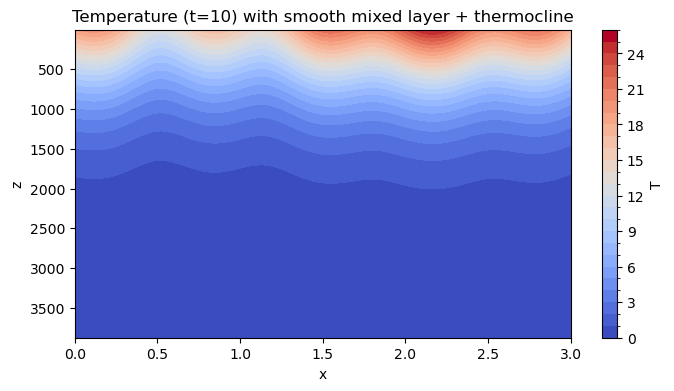

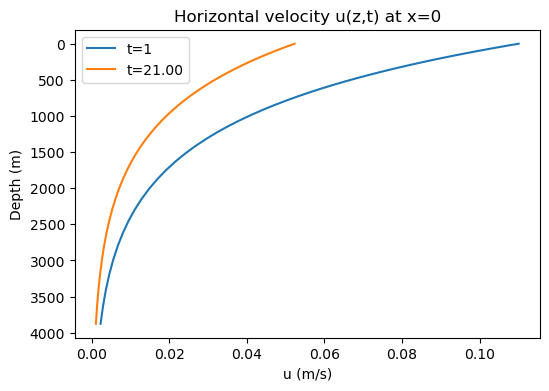

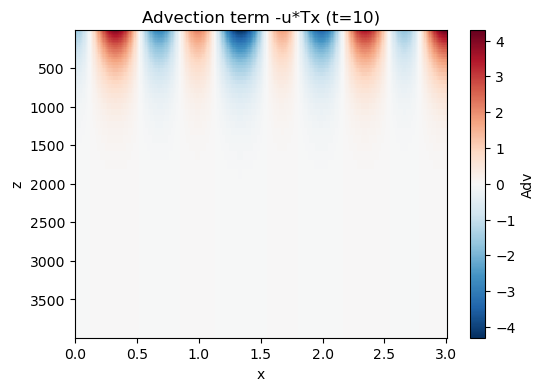

In [10]:
# =========================
# 10. Visualization examples
# =========================
# Temperature at t=10
plt.figure(figsize=(8,4))
T_da.sel(t=10, method='nearest').plot.contourf(x='x', y='z', cmap='coolwarm', yincrease=False,levels=30)
plt.title('Temperature (t=10) with smooth mixed layer + thermocline')
plt.show()

# Horizontal velocity u(z,t) vertical profile at x=0
x_idx = 0
plt.figure(figsize=(6,4))
plt.plot(u_da.isel(t=0,x=x_idx), z, label='t=1')
plt.plot(u_da.isel(t=len(t)//2,x=x_idx), z, label=f't={t[len(t)//2]:.2f}')
plt.xlabel('u (m/s)')
plt.ylabel('Depth (m)')
plt.gca().invert_yaxis()
plt.title('Horizontal velocity u(z,t) at x=0')
plt.legend()
plt.show()

# Advection term -u*Tx at t=10
plt.figure(figsize=(6,4))
adv_da.sel(t=10, method='nearest').plot(x='x', y='z', yincrease=False)
plt.title('Advection term -u*Tx (t=10)')
plt.show()


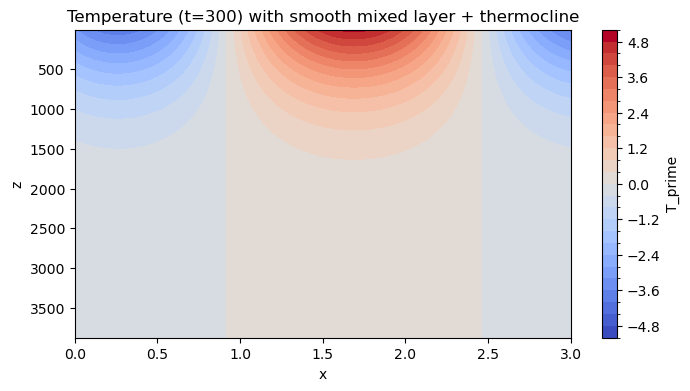

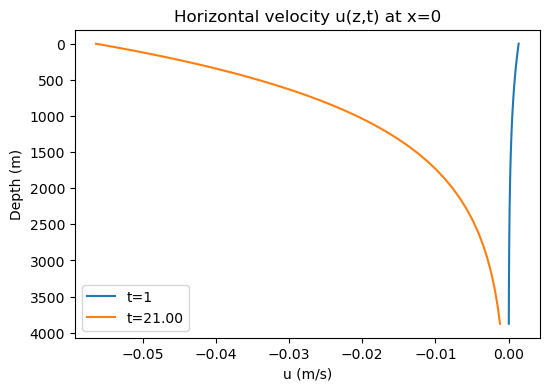

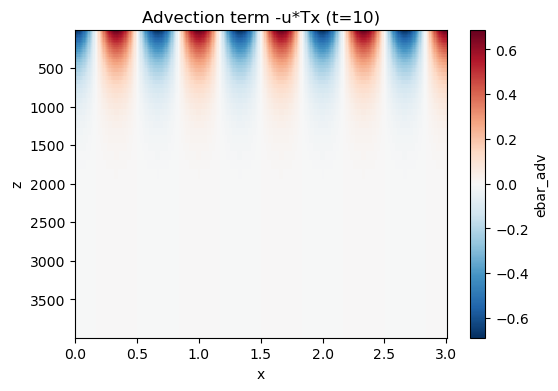

In [11]:
# =========================
# 10. Visualization examples
# =========================
# Temperature at t=10
plt.figure(figsize=(8,4))
T_prime_da.sel(t=300, method='nearest').plot.contourf(x='x', y='z', cmap='coolwarm', yincrease=False,levels=30)
plt.title('Temperature (t=300) with smooth mixed layer + thermocline')
plt.show()

# Horizontal velocity u(z,t) vertical profile at x=0
x_idx = 0
plt.figure(figsize=(6,4))
plt.plot(U_prime_da.isel(t=0,x=x_idx), z, label='t=1')
plt.plot(U_prime_da.isel(t=len(t)//2,x=x_idx), z, label=f't={t[len(t)//2]:.2f}')
plt.xlabel('u (m/s)')
plt.ylabel('Depth (m)')
plt.gca().invert_yaxis()
plt.title('Horizontal velocity u(z,t) at x=0')
plt.legend()
plt.show()

# Advection term -u*Tx at t=10
plt.figure(figsize=(6,4))
ebar_adv_da.sel(t=10, method='nearest').plot(x='x', y='z', yincrease=False)
plt.title('Advection term -u*Tx (t=10)')
plt.show()

#  normal watermass budget 

In [5]:
import numpy as np
import xarray as xr
import xgcm

# Left boundary: keep original values at x=0, zero elsewhere
adv_lda = xr.zeros_like(u_da)
adv_lda.loc[dict(x=0.0)] = u_da.loc[dict(x=0.0)]

# Right boundary: keep original values at x=3, zero elsewhere
adv_rda = xr.zeros_like(u_da)
adv_rda.loc[dict(x=3.0)] = u_da.loc[dict(x=3.0)]


# -----------------------------
# 构建 outer 坐标和 dx_array
# -----------------------------
# -----------------------------
# Construct outer z coordinates and dz array
# -----------------------------
z_outer = np.empty(len(z)+1)

# Interior faces: midpoints between layer centers
z_outer[1:-1] = 0.5 * (z[:-1] + z[1:])

# Surface face: assume first layer thickness extends from slightly above surface to first center
z_outer[0] = z[0] - 0.5 * (z[1]-z[0])   # slightly above first layer center

# Bottom face: extend from last layer center
z_outer[-1] = z[-1] + 0.5 * (z[-1]-z[-2])

# Convert to xarray DataArray
z_outer_da = xr.DataArray(z_outer, dims=['z_outer'])

# Compute layer thicknesses
dz_array = np.diff(z_outer)
# dz_array only depends on z, shape (Nz,)
dz_da = xr.DataArray(dz_array, dims=['z'], coords={'z': z})

# Expand to time and x dimensions (broadcasting)
dz_da = dz_da.expand_dims({'t': t, 'x': x})  # dims will be ('z','t','x')

# Reorder dimensions to ('t','x','z')
dz_da = dz_da.transpose('t','x','z')

# Horizontal spacing
dx_array = np.diff(x)             # length Nx-1
dx_array = np.append(dx_array, dx_array[-1])  # make same length as x

dx_da = xr.DataArray(dx_array, dims=['x'], coords={'x': x})

# Compute 2D cell area (x,z) for each time
# dz_da already has shape (t,x,z)
area_da = dx_da * dz_da           # broadcasting: (t,x) * (t,x,z) -> (t,x,z)
area_da = area_da.transpose('t','x','z')


In [11]:

# -----------------------------
# tcenter bin
# -----------------------------
dtcenters = 0.02
tcenters = np.arange(0,27+dtcenters,dtcenters)

tcen_outer = np.empty(len(tcenters)+1)
tcen_outer[1:-1] = 0.5 * (tcenters[:-1] + tcenters[1:])
tcen_outer[0] = tcenters[0] - 0.5*dtcenters
tcen_outer[-1] = tcenters[-1] + 0.5*dtcenters
tcen_outer = xr.DataArray(tcen_outer, dims=['tcenter'])

# -----------------------------
# 构建 Dataset 和 xgcm Grid
# -----------------------------

ds = xr.Dataset({
    'dz': dz_da,
    'T' : T_da,
    'Tdot':     (Tdot_da*area_da ).transpose('t','x','z'),
    'adv_left': (adv_lda*dz_da  ).transpose('t','x','z'),
    'adv_right':(adv_rda*dz_da   ).transpose('t','x','z') })
ds = ds.assign_coords({'z_outer': z_outer})
grid = xgcm.Grid(ds, coords={'Z':{'center':'z', 'outer':'z_outer'}}, periodic=False, autoparse_metadata=False)
#grid = xgcm.Grid(ds, coords={'X':{'center':'x'}}, periodic=False, autoparse_metadata=False)


ds['T_outer'] = grid.interp(ds.T, 'Z', boundary='extend')

In [13]:
# -----------------------------
# conservative transform
# -----------------------------
thickness = grid.transform(ds['dz'], 'Z', 
    target=tcen_outer,
    method='conservative',
    target_data=ds.T_outer)

Tdot_theta = grid.transform(ds['Tdot'], 'Z', 
    target=tcen_outer, 
    method='conservative',
    target_data=ds.T_outer)

ladv_theta = grid.transform(ds['adv_left'], 'Z', 
    target=tcen_outer, 
    method='conservative',
    target_data=ds.T_outer)

radv_theta = grid.transform(ds['adv_right'], 'Z', 
    target=tcen_outer, 
    method='conservative',
    target_data=ds.T_outer)

thickness = thickness.fillna(0)
Tdot_theta = Tdot_theta.fillna(0)
ladv_theta = ladv_theta.fillna(0)
radv_theta = radv_theta.fillna(0)


# make a cumlative calculation to compare with method based on mask

In [14]:

# -----------------------------
# cumulative > tcenter
# -----------------------------
M = (thickness*dx_da).sum('x').isel(tcenter=slice(None, None, -1)).cumsum(dim='tcenter').isel(tcenter=slice(None, None, -1))
M_trend = M.diff('t') / dt 
M_trend = M_trend.assign_coords({'t': t[0:-1]})

# budgets
gmat = np.zeros([len(t), len(tcenters)])
for i in range(0,len(tcenters)-1):
    gmat[:,i] = ( np.sum(Tdot_theta[:,:,i].values,axis=1) + np.sum(Tdot_theta[:,:,i-1].values, axis=1) )/2/dtcenters

gmat = xr.DataArray(gmat,
    dims=['t', 'tcenter'],
    coords={'t': t, 'tcenter': tcenters})

#
#gadv = ladv_theta[0:-1,:]  - radv_theta[0:-1,:]
#gadv_cum = gadv.isel(tcenter=slice(None, None, -1)).cumsum(dim='tcenter').isel(tcenter=slice(None, None, -1))

ladv_theta_cum = ladv_theta.sum('x').isel(tcenter=slice(None, None, -1)).cumsum(dim='tcenter').isel(tcenter=slice(None, None, -1))
radv_theta_cum = radv_theta.sum('x').isel(tcenter=slice(None, None, -1)).cumsum(dim='tcenter').isel(tcenter=slice(None, None, -1))
gadv_cum       = ladv_theta_cum - radv_theta_cum

# see some budgets if they are close

Text(0, 0.5, 'Value')

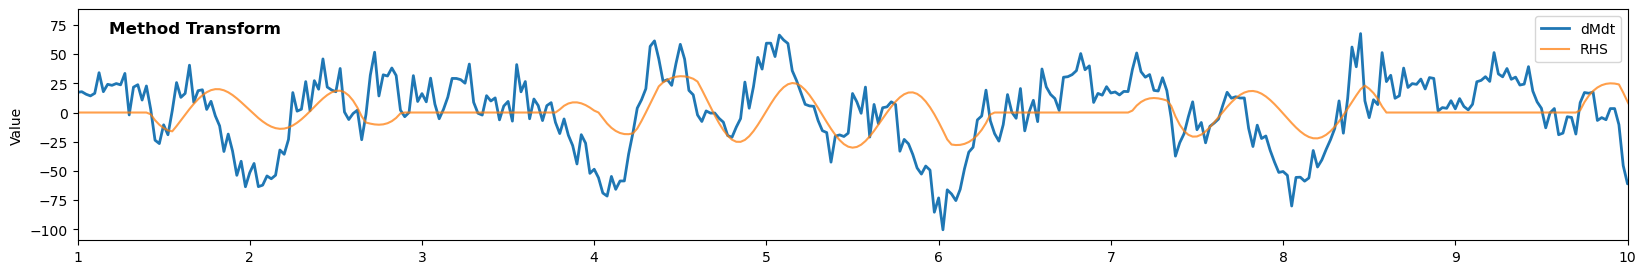

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 3), sharex=True,sharey=True)

# 上行：方法0
ax.plot(M_trend.t.values, M_trend.isel(tcenter=800).values - gmat[0:-1].isel(tcenter=800).values, label='dMdt', linewidth=2)
ax.plot(gadv_cum.t[0:-1].values,  gadv_cum[0:-1].isel(tcenter=800).values  , 
      label='RHS', alpha=0.75)
ax.legend(loc='upper right')  # 图例放右上角，避免覆盖文字
ax.text(0.02, 0.95, 'Method Transform', transform=ax.transAxes,
      fontsize=12, fontweight='bold', va='top', ha='left')
ax.set_xlim(1,10)
#ax.set_ylim(-50,50)
ax.set_ylabel('Value')

Text(0, 0.5, 'Value')

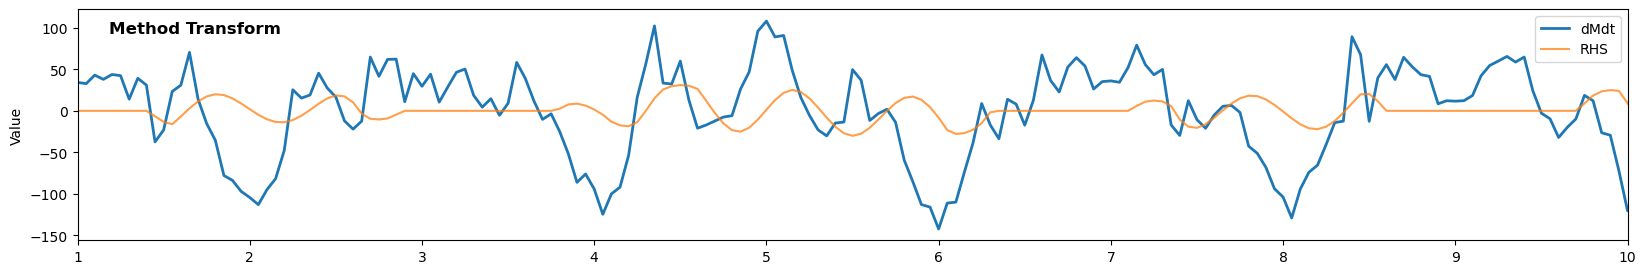

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 3), sharex=True,sharey=True)

# 上行：方法0
ax.plot(M_trend.t.values, M_trend.isel(tcenter=800).values - gmat[0:-1].isel(tcenter=800).values, label='dMdt', linewidth=2)
ax.plot(gadv_cum.t[0:-1].values,  gadv_cum[0:-1].isel(tcenter=800).values  , 
      label='RHS', alpha=0.75)
ax.legend(loc='upper right')  # 图例放右上角，避免覆盖文字
ax.text(0.02, 0.95, 'Method Transform', transform=ax.transAxes,
      fontsize=12, fontweight='bold', va='top', ha='left')
ax.set_xlim(1,10)
#ax.set_ylim(-50,50)
ax.set_ylabel('Value')

Text(0, 0.5, 'Value')

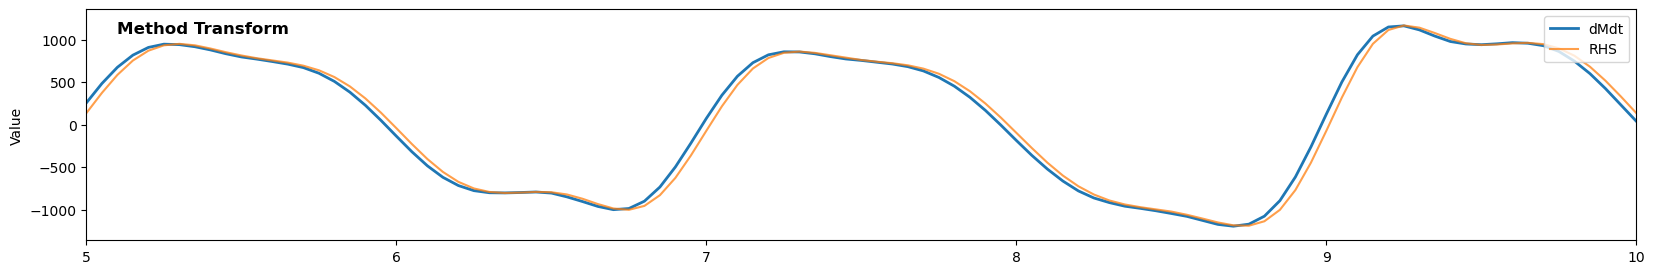

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 3), sharex=True,sharey=True)

# 上行：方法0
ax.plot(M_trend.t.values, M_trend.isel(tcenter=200).values, label='dMdt', linewidth=2)
ax.plot(gadv_cum.t[0:-1].values,  gmat[0:-1].isel(tcenter=200).values + gadv_cum[0:-1].isel(tcenter=200).values  , 
      label='RHS', alpha=0.75)
ax.legend(loc='upper right')  # 图例放右上角，避免覆盖文字
ax.text(0.02, 0.95, 'Method Transform', transform=ax.transAxes,
      fontsize=12, fontweight='bold', va='top', ha='left')
ax.set_xlim(5,10)
#ax.set_ylim(-50,50)
ax.set_ylabel('Value')


Text(0, 0.5, 'Value')

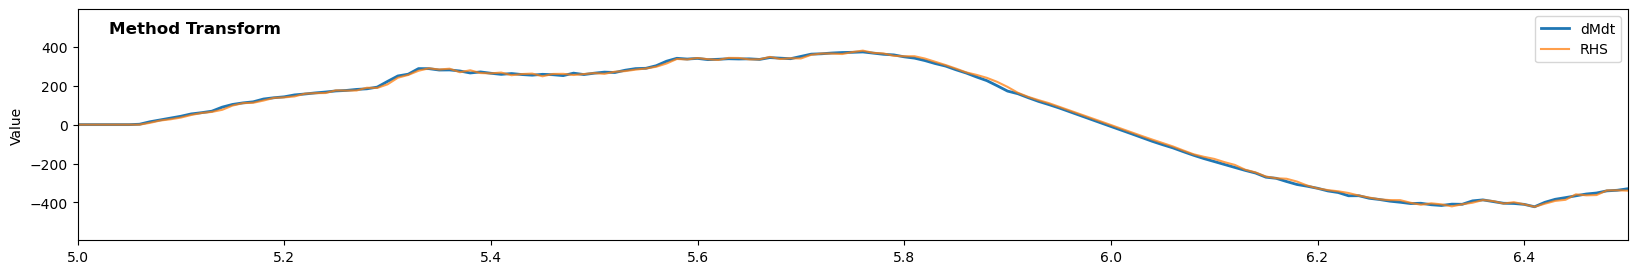

In [111]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 3), sharex=True,sharey=True)

# 上行：方法0
ax.plot(thickness_trend.t, M_trend.isel(tcenter=400), label='dMdt', linewidth=2)
ax.plot(gadv_cum.t[0:-1],  gmat[0:-1].isel(tcenter=400).values + gadv_cum[0:-1].isel(tcenter=400).values  , 
      label='RHS', alpha=0.75)
ax.legend(loc='upper right')  # 图例放右上角，避免覆盖文字
ax.text(0.02, 0.95, 'Method Transform', transform=ax.transAxes,
      fontsize=12, fontweight='bold', va='top', ha='left')
ax.set_xlim(5,6.5)
#ax.set_ylim(-50,50)
ax.set_ylabel('Value')

Text(0, 0.5, 'Value')

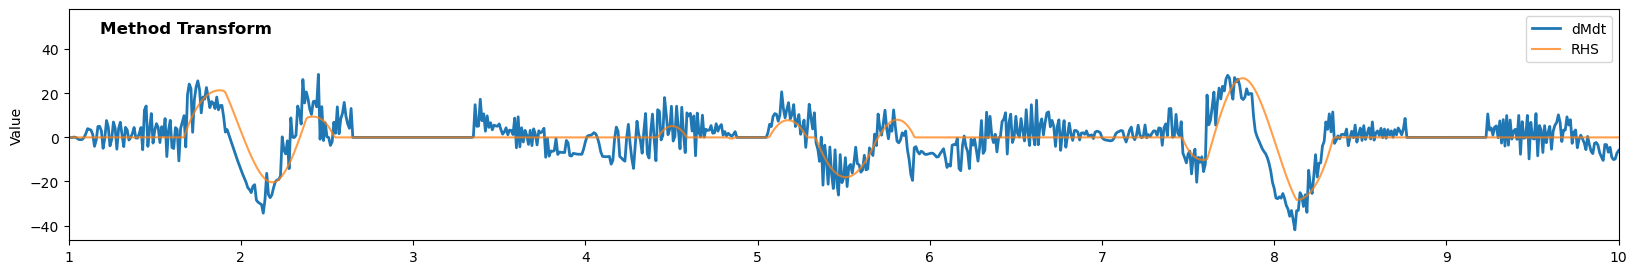

In [113]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 3), sharex=True,sharey=True)

# 上行：方法0
ax.plot(thickness_trend.t.values, M_trend.isel(tcenter=400).values - gmat[0:-1].isel(tcenter=400).values, label='dMdt', linewidth=2)
ax.plot(gadv_cum.t[0:-1].values,  gadv_cum[0:-1].isel(tcenter=400).values  , 
      label='RHS', alpha=0.75)
ax.legend(loc='upper right')  # 图例放右上角，避免覆盖文字
ax.text(0.02, 0.95, 'Method Transform', transform=ax.transAxes,
      fontsize=12, fontweight='bold', va='top', ha='left')
ax.set_xlim(1,10)
#ax.set_ylim(-50,50)
ax.set_ylabel('Value')

# anomaly watermass budget 

In [16]:
import numpy as np
import xarray as xr
import xgcm

# Left boundary: keep original values at x=0, zero elsewhere
adv_lda = xr.zeros_like(u_da)
adv_lda.loc[dict(x=0.0)] = u_da.loc[dict(x=0.0)]

# Right boundary: keep original values at x=3, zero elsewhere
adv_rda = xr.zeros_like(u_da)
adv_rda.loc[dict(x=3.0)] = u_da.loc[dict(x=3.0)]


# -----------------------------
# 构建 outer 坐标和 dx_array
# -----------------------------
# -----------------------------
# Construct outer z coordinates and dz array
# -----------------------------
z_outer = np.empty(len(z)+1)

# Interior faces: midpoints between layer centers
z_outer[1:-1] = 0.5 * (z[:-1] + z[1:])

# Surface face: assume first layer thickness extends from slightly above surface to first center
z_outer[0] = z[0] - 0.5 * (z[1]-z[0])   # slightly above first layer center

# Bottom face: extend from last layer center
z_outer[-1] = z[-1] + 0.5 * (z[-1]-z[-2])

# Convert to xarray DataArray
z_outer_da = xr.DataArray(z_outer, dims=['z_outer'])

# Compute layer thicknesses
dz_array = np.diff(z_outer)
# dz_array only depends on z, shape (Nz,)
dz_da = xr.DataArray(dz_array, dims=['z'], coords={'z': z})

# Expand to time and x dimensions (broadcasting)
dz_da = dz_da.expand_dims({'t': t, 'x': x})  # dims will be ('z','t','x')

# Reorder dimensions to ('t','x','z')
dz_da = dz_da.transpose('t','x','z')

# Horizontal spacing
dx_array = np.diff(x)             # length Nx-1
dx_array = np.append(dx_array, dx_array[-1])  # make same length as x

dx_da = xr.DataArray(dx_array, dims=['x'], coords={'x': x})

# Compute 2D cell area (x,z) for each time
# dz_da already has shape (t,x,z)
area_da = dx_da * dz_da           # broadcasting: (t,x) * (t,x,z) -> (t,x,z)
area_da = area_da.transpose('t','x','z')



# prepare the tcenter bins based on quantile method
### compare 100 bins, 200 bins, 400 bins, 600 bins
### find that more bins more than 100 makes aw worse budgets' close 

In [45]:
import numpy as np
import xarray as xr

# 1️⃣ 取出所有非 NaN 温度样本
T_flat = Tdot_prime_da.values.flatten()
T_flat = T_flat[~np.isnan(T_flat)]

# 2️⃣ 按分位数确定边界（比如分成 100 个 bin）
n_bins = 100
quantiles = np.linspace(0, 1, n_bins + 1)
t_edges = np.quantile(T_flat, quantiles)

# 3️⃣ 根据边界计算中心值
tcenters = 0.5 * (t_edges[:-1] + t_edges[1:])
dtcenters = np.diff(t_edges)  # 每个 bin 的温度宽度（非均匀）

# 4️⃣ 转成 DataArray
#tcenters = xr.DataArray(tcenters, dims=['tcenter'])
#t_edges  = xr.DataArray(t_edges,  dims=['touter'])
tcen_outer = xr.DataArray(t_edges, dims=['tcenter'])

# prepare the tcenter bins based on linspace method

In [ ]:
# -----------------------------
# 定义目标温度 bin
# -----------------------------
dtcenters = 0.02
tcenters = np.arange(-5.6,5.6+dtcenters,dtcenters)

tcen_outer = np.empty(len(tcenters)+1)
tcen_outer[1:-1] = 0.5 * (tcenters[:-1] + tcenters[1:])
tcen_outer[0] = tcenters[0] - 0.5*dtcenters
tcen_outer[-1] = tcenters[-1] + 0.5*dtcenters
tcen_outer = xr.DataArray(tcen_outer, dims=['tcenter'])


# calculating wmb using transform method

In [46]:
# -----------------------------
# 构建 Dataset 和 xgcm Grid
# -----------------------------

ds_anom = xr.Dataset({
    'dz': dz_da,
    'T' : T_prime_da,
    'Tdot':     (Tdot_prime_da*area_da ).transpose('t','x','z'),
    'upTb':     (ebar_adv_da*area_da ).transpose('t','x','z'),
    'upTp':     (eddy_adv_da*area_da ).transpose('t','x','z'),
    'adv_left': (adv_lda*dz_da  ).transpose('t','x','z'),
    'adv_right':(adv_rda*dz_da   ).transpose('t','x','z') })
ds_anom = ds_anom.assign_coords({'z_outer': z_outer})
grid = xgcm.Grid(ds_anom, coords={'Z':{'center':'z', 'outer':'z_outer'}}, periodic=False, autoparse_metadata=False)
#grid = xgcm.Grid(ds, coords={'X':{'center':'x'}}, periodic=False, autoparse_metadata=False)


ds_anom['T_outer'] = grid.interp(ds_anom.T, 'Z', boundary='extend')

# -----------------------------
# conservative transform
# -----------------------------
thickness = grid.transform(ds_anom['dz'], 'Z', 
    target=tcen_outer,
    method='conservative',
    target_data=ds_anom.T_outer)

Tdot_theta = grid.transform(ds_anom['Tdot'], 'Z', 
    target=tcen_outer, 
    method='conservative',
    target_data=ds_anom.T_outer)

upTb_theta = grid.transform(ds_anom['upTb'], 'Z', 
    target=tcen_outer, 
    method='conservative',
    target_data=ds_anom.T_outer)

upTp_theta = grid.transform(ds_anom['upTp'], 'Z', 
    target=tcen_outer, 
    method='conservative',
    target_data=ds_anom.T_outer)

ladv_theta = grid.transform(ds_anom['adv_left'], 'Z', 
    target=tcen_outer, 
    method='conservative',
    target_data=ds_anom.T_outer)

radv_theta = grid.transform(ds_anom['adv_right'], 'Z', 
    target=tcen_outer, 
    method='conservative',
    target_data=ds_anom.T_outer)

thickness = thickness.fillna(0)
Tdot_theta = Tdot_theta.fillna(0)
upTb_theta = upTb_theta.fillna(0)
upTp_theta = upTp_theta.fillna(0)
ladv_theta = ladv_theta.fillna(0)
radv_theta = radv_theta.fillna(0)


# cumulative again for un-uniform zgrid

In [47]:

# -----------------------------
# cumulative > tcenter
# -----------------------------
M = (thickness*dx_da).sum('x').isel(tcenter=slice(None, None, -1)).cumsum(dim='tcenter').isel(tcenter=slice(None, None, -1))
M_trend = M.diff('t') / dt 
M_trend = M_trend.assign_coords({'t': t[0:-1]})

# budgets
gmat = np.zeros([len(t), len(tcenters)])
for i in range(0,len(tcenters)-1):
    gmat[:,i] = ( np.sum(Tdot_theta[:,:,i].values,axis=1) + np.sum(Tdot_theta[:,:,i-1].values, axis=1) )/(dtcenters[i]+dtcenters[i-1])

gmat = xr.DataArray(gmat,
    dims=['t', 'tcenter'],
    coords={'t': t, 'tcenter': tcenters})


# upTp
gupTp = np.zeros([len(t), len(tcenters)])
for i in range(0,len(tcenters)-1):
    gupTp[:,i] = ( np.sum(upTp_theta[:,:,i].values,axis=1) + np.sum(upTp_theta[:,:,i-1].values, axis=1) )/(dtcenters[i]+dtcenters[i-1])

gupTp = xr.DataArray(gupTp,
    dims=['t', 'tcenter'],
    coords={'t': t, 'tcenter': tcenters})


# upTb
gupTb = np.zeros([len(t), len(tcenters)])
for i in range(0,len(tcenters)-1):
    gupTb[:,i] = ( np.sum(upTb_theta[:,:,i].values,axis=1) + np.sum(upTb_theta[:,:,i-1].values, axis=1) )/(dtcenters[i]+dtcenters[i-1])

gupTb = xr.DataArray(gupTb,
    dims=['t', 'tcenter'],
    coords={'t': t, 'tcenter': tcenters})

#
#gadv = ladv_theta[0:-1,:]  - radv_theta[0:-1,:]
#gadv_cum = gadv.isel(tcenter=slice(None, None, -1)).cumsum(dim='tcenter').isel(tcenter=slice(None, None, -1))

ladv_theta_cum = ladv_theta.sum('x').isel(tcenter=slice(None, None, -1)).cumsum(dim='tcenter').isel(tcenter=slice(None, None, -1))
radv_theta_cum = radv_theta.sum('x').isel(tcenter=slice(None, None, -1)).cumsum(dim='tcenter').isel(tcenter=slice(None, None, -1))
gadv_cum       = ladv_theta_cum - radv_theta_cum

# cumulative again for uniform zgrid

In [ ]:
# -----------------------------
# cumulative > tcenter
# -----------------------------
M = (thickness*dx_da).sum('x').isel(tcenter=slice(None, None, -1)).cumsum(dim='tcenter').isel(tcenter=slice(None, None, -1))
M_trend = M.diff('t') / dt 
M_trend = M_trend.assign_coords({'t': t[0:-1]})

# budgets
gmat = np.zeros([len(t), len(tcenters)])
for i in range(0,len(tcenters)-1):
    gmat[:,i] = ( np.sum(Tdot_theta[:,:,i].values,axis=1) + np.sum(Tdot_theta[:,:,i-1].values, axis=1) )/2/dtcenters

gmat = xr.DataArray(gmat,
    dims=['t', 'tcenter'],
    coords={'t': t, 'tcenter': tcenters})


# upTp
gupTp = np.zeros([len(t), len(tcenters)])
for i in range(0,len(tcenters)-1):
    gupTp[:,i] = ( np.sum(upTp_theta[:,:,i].values,axis=1) + np.sum(upTp_theta[:,:,i-1].values, axis=1) )/2/dtcenters

gupTp = xr.DataArray(gupTp,
    dims=['t', 'tcenter'],
    coords={'t': t, 'tcenter': tcenters})


# upTb
gupTb = np.zeros([len(t), len(tcenters)])
for i in range(0,len(tcenters)-1):
    gupTb[:,i] = ( np.sum(upTb_theta[:,:,i].values,axis=1) + np.sum(upTb_theta[:,:,i-1].values, axis=1) )/2/dtcenters

gupTb = xr.DataArray(gupTb,
    dims=['t', 'tcenter'],
    coords={'t': t, 'tcenter': tcenters})

#
#gadv = ladv_theta[0:-1,:]  - radv_theta[0:-1,:]
#gadv_cum = gadv.isel(tcenter=slice(None, None, -1)).cumsum(dim='tcenter').isel(tcenter=slice(None, None, -1))

ladv_theta_cum = ladv_theta.sum('x').isel(tcenter=slice(None, None, -1)).cumsum(dim='tcenter').isel(tcenter=slice(None, None, -1))
radv_theta_cum = radv_theta.sum('x').isel(tcenter=slice(None, None, -1)).cumsum(dim='tcenter').isel(tcenter=slice(None, None, -1))
gadv_cum       = ladv_theta_cum - radv_theta_cum



# see

(-0.04, 0.04)

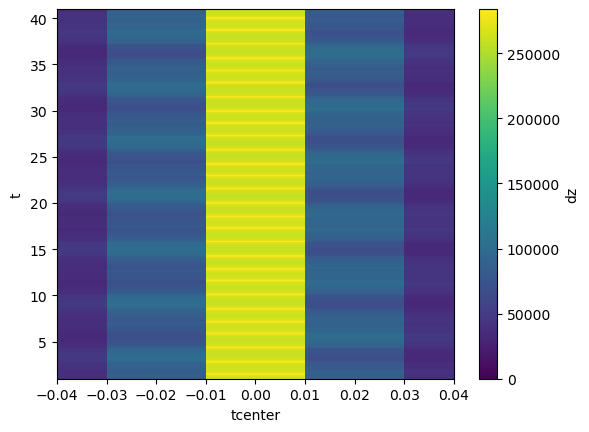

In [23]:
thickness.sum('x').plot()
plt.xlim(-0.04,0.04)

(-0.1, 0.1)

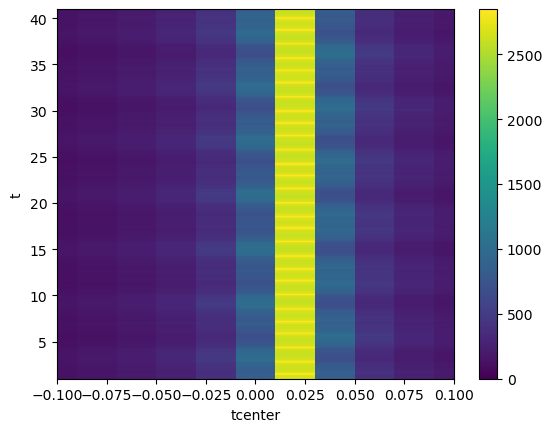

In [20]:
(-M.diff("tcenter")).plot()
plt.xlim(-0.1,0.1)

Text(0, 0.5, 'Value')

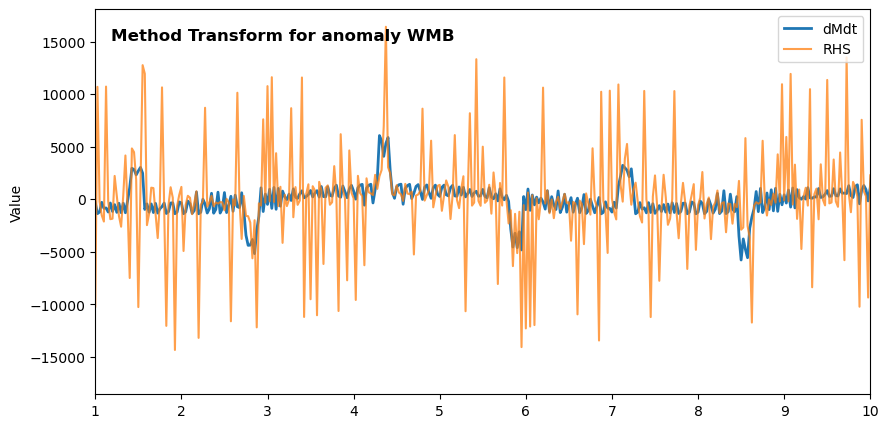

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True,sharey=True)

# 上行：方法0
ax.plot(M_trend.t.values, M_trend.isel(tcenter=100).values, label='dMdt', linewidth=2)
ax.plot(gadv_cum.t[0:-1].values,  gmat[0:-1].isel(tcenter=100).values + gadv_cum[0:-1].isel(tcenter=100).values + gupTb[0:-1].isel(tcenter=100).values +  gupTp[0:-1].isel(tcenter=100).values , 
      label='RHS', alpha=0.75)
ax.legend(loc='upper right')  # 图例放右上角，避免覆盖文字
ax.text(0.02, 0.95, 'Method Transform for anomaly WMB', transform=ax.transAxes,
      fontsize=12, fontweight='bold', va='top', ha='left')
ax.set_xlim(1,10)
#ax.set_ylim(-50,50)
ax.set_ylabel('Value')

Text(0, 0.5, 'Value')

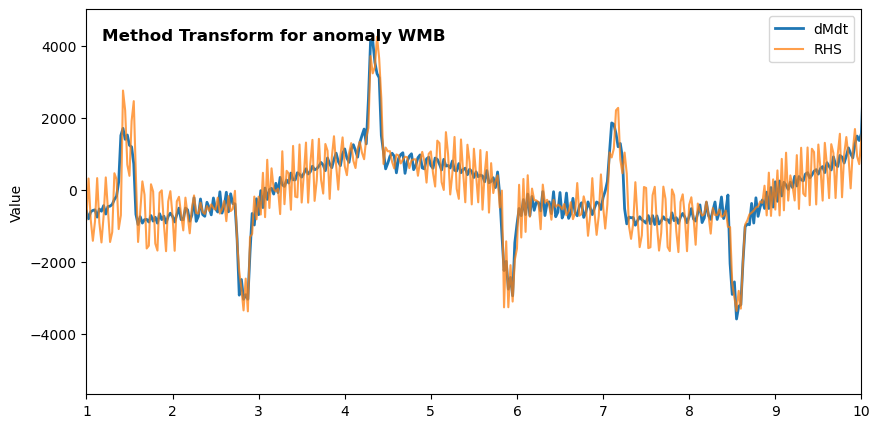

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True,sharey=True)

# 上行：方法0
ax.plot(M_trend.t.values, M_trend.isel(tcenter=280).values, label='dMdt', linewidth=2)
ax.plot(gadv_cum.t[0:-1].values,  gmat[0:-1].isel(tcenter=280).values + gadv_cum[0:-1].isel(tcenter=280).values + gupTb[0:-1].isel(tcenter=280).values +  gupTp[0:-1].isel(tcenter=280).values , 
      label='RHS', alpha=0.75)
ax.legend(loc='upper right')  # 图例放右上角，避免覆盖文字
ax.text(0.02, 0.95, 'Method Transform for anomaly WMB', transform=ax.transAxes,
      fontsize=12, fontweight='bold', va='top', ha='left')
ax.set_xlim(1,10)
#ax.set_ylim(-50,50)
ax.set_ylabel('Value')

Text(0, 0.5, 'Value')

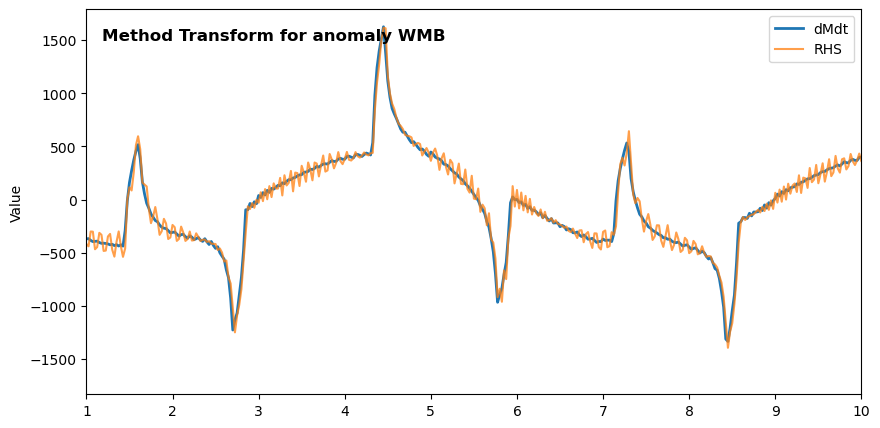

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True,sharey=True)

# 上行：方法0
ax.plot(M_trend.t.values, M_trend.isel(tcenter=300).values, label='dMdt', linewidth=2)
ax.plot(gadv_cum.t[0:-1].values,  gmat[0:-1].isel(tcenter=300).values + gadv_cum[0:-1].isel(tcenter=300).values + gupTb[0:-1].isel(tcenter=300).values +  gupTp[0:-1].isel(tcenter=300).values , 
      label='RHS', alpha=0.75)
ax.legend(loc='upper right')  # 图例放右上角，避免覆盖文字
ax.text(0.02, 0.95, 'Method Transform for anomaly WMB', transform=ax.transAxes,
      fontsize=12, fontweight='bold', va='top', ha='left')
ax.set_xlim(1,10)
#ax.set_ylim(-50,50)
ax.set_ylabel('Value')

Text(0, 0.5, 'Value')

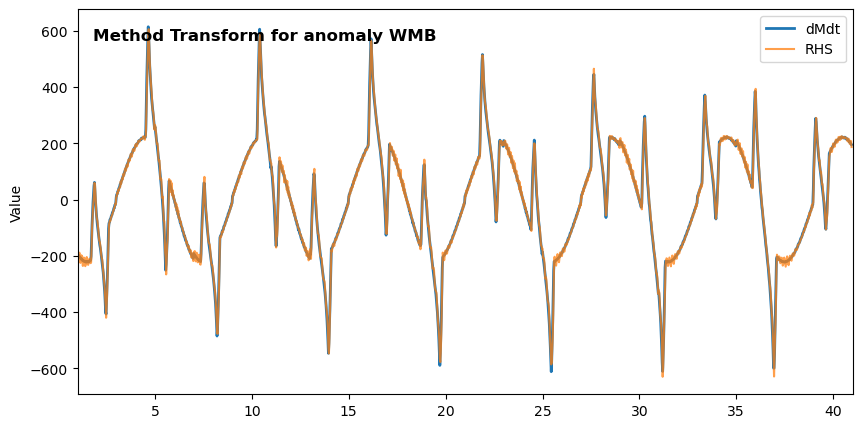

In [68]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True,sharey=True)

# 上行：方法0
ax.plot(M_trend.t.values, M_trend.isel(tcenter=280).values, label='dMdt', linewidth=2)
ax.plot(gadv_cum.t[0:-1].values,  gmat[0:-1].isel(tcenter=280).values + gadv_cum[0:-1].isel(tcenter=280).values + gupTb[0:-1].isel(tcenter=280).values +  gupTp[0:-1].isel(tcenter=280).values, 
      label='RHS', alpha=0.75)
ax.legend(loc='upper right')  # 图例放右上角，避免覆盖文字
ax.text(0.02, 0.95, 'Method Transform for anomaly WMB', transform=ax.transAxes,
      fontsize=12, fontweight='bold', va='top', ha='left')
ax.set_xlim(1,41)
#ax.set_ylim(-50,50)
ax.set_ylabel('Value')

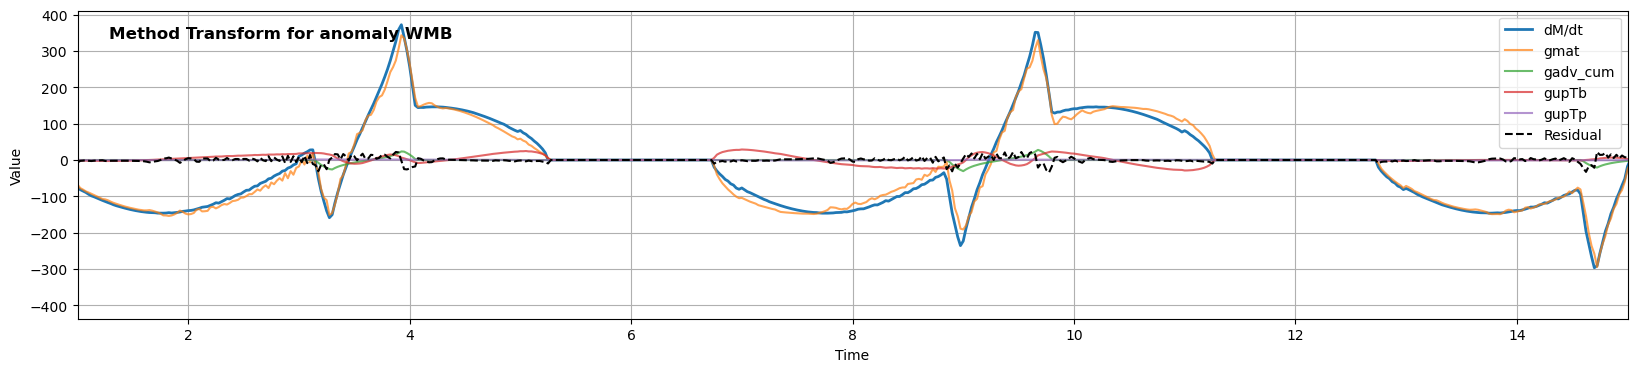

In [56]:
import matplotlib.pyplot as plt

# Select index
idx = 100

# Compute RHS and residual
RHS = gmat.isel(tcenter=idx).values + gadv_cum.isel(tcenter=idx).values + \
      gupTb.isel(tcenter=idx).values + gupTp.isel(tcenter=idx).values

residual = M_trend.isel(tcenter=idx).values - RHS[0:-1]

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(20, 4))

# Plot each component
ax.plot(M_trend.t.values, M_trend.isel(tcenter=idx).values, label='dM/dt', linewidth=2)
ax.plot(gmat.t.values, gmat.isel(tcenter=idx).values, label='gmat', alpha=0.7)
ax.plot(gadv_cum.t.values, gadv_cum.isel(tcenter=idx).values, label='gadv_cum', alpha=0.7)
ax.plot(gupTb.t.values, gupTb.isel(tcenter=idx).values, label='gupTb', alpha=0.7)
ax.plot(gupTp.t.values, gupTp.isel(tcenter=idx).values, label='gupTp', alpha=0.7)

# Plot residual
ax.plot(M_trend.t.values, residual, 'k--', label='Residual', linewidth=1.5)

# Legend and labels
ax.legend(loc='upper right')
ax.text(0.02, 0.95, 'Method Transform for anomaly WMB', transform=ax.transAxes,
        fontsize=12, fontweight='bold', va='top', ha='left')
ax.set_ylabel('Value')
ax.set_xlabel('Time')
ax.grid(True)
ax.set_xlim(1,15)
plt.show()


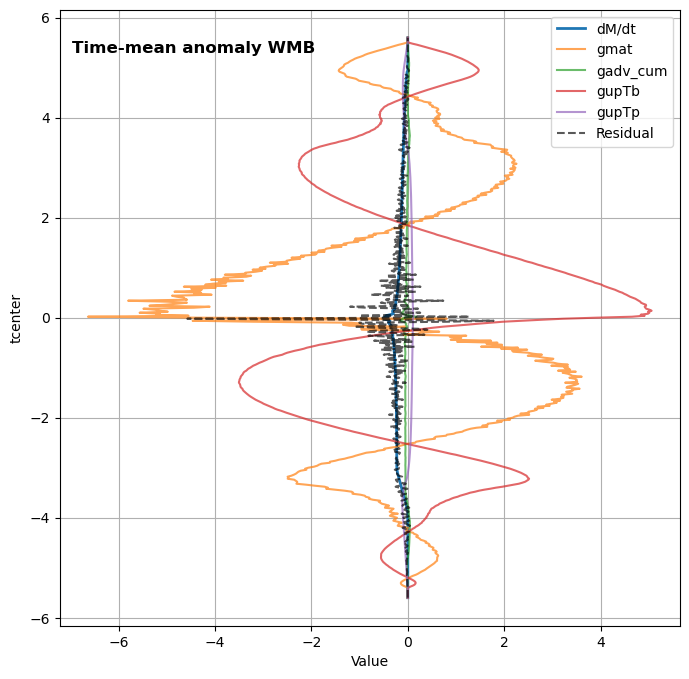

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Compute time-mean of each term along t dimension
M_trend_mean = M_trend.mean(dim='t')
gmat_mean = gmat.mean(dim='t')
gadv_cum_mean = gadv_cum.mean(dim='t')
gupTb_mean = gupTb.mean(dim='t')
gupTp_mean = gupTp.mean(dim='t')

# Compute time-mean residual
RHS_mean = gmat_mean + gadv_cum_mean + gupTb_mean + gupTp_mean
residual_mean = M_trend_mean - RHS_mean

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(8, 8))  # tall figure for vertical orientation

# Plot each term with tcenter on y-axis
ax.plot(M_trend_mean.values, M_trend.tcenter.values, label='dM/dt', linewidth=2)
ax.plot(gmat_mean.values, gmat.tcenter.values, label='gmat', alpha=0.7)
ax.plot(gadv_cum_mean.values, gadv_cum.tcenter.values, label='gadv_cum', alpha=0.7)
ax.plot(gupTb_mean.values, gupTb.tcenter.values, label='gupTb', alpha=0.7)
ax.plot(gupTp_mean.values, gupTp.tcenter.values, label='gupTp', alpha=0.7)
ax.plot(residual_mean.values, M_trend.tcenter.values, 'k--', label='Residual', linewidth=1.5,alpha=0.65)

# Labels, legend
ax.set_ylabel('tcenter')
ax.set_xlabel('Value')
ax.legend(loc='upper right')
ax.text(0.02, 0.95, 'Time-mean anomaly WMB', transform=ax.transAxes,
        fontsize=12, fontweight='bold', va='top', ha='left')
ax.grid(True)
plt.show()


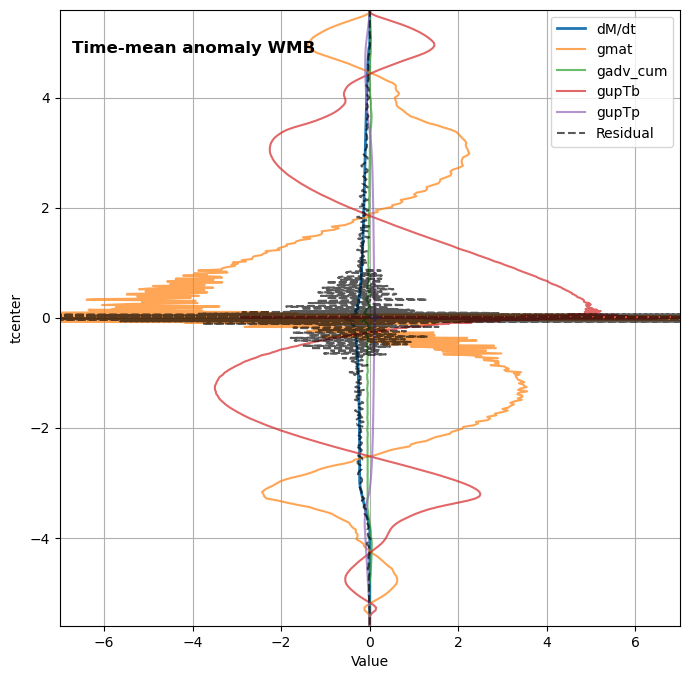

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Compute time-mean of each term along t dimension
M_trend_mean = M_trend.mean(dim='t')
gmat_mean = gmat.mean(dim='t')
gadv_cum_mean = gadv_cum.mean(dim='t')
gupTb_mean = gupTb.mean(dim='t')
gupTp_mean = gupTp.mean(dim='t')

# Compute time-mean residual
RHS_mean = gmat_mean + gadv_cum_mean + gupTb_mean + gupTp_mean
residual_mean = M_trend_mean - RHS_mean

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(8, 8))  # tall figure for vertical orientation

# Plot each term with tcenter on y-axis
ax.plot(M_trend_mean.values, M_trend.tcenter.values, label='dM/dt', linewidth=2)
ax.plot(gmat_mean.values, gmat.tcenter.values, label='gmat', alpha=0.7)
ax.plot(gadv_cum_mean.values, gadv_cum.tcenter.values, label='gadv_cum', alpha=0.7)
ax.plot(gupTb_mean.values, gupTb.tcenter.values, label='gupTb', alpha=0.7)
ax.plot(gupTp_mean.values, gupTp.tcenter.values, label='gupTp', alpha=0.7)
ax.plot(residual_mean.values, M_trend.tcenter.values, 'k--', label='Residual', linewidth=1.5,alpha=0.65)

# Labels, legend
ax.set_ylabel('tcenter')
ax.set_xlabel('Value')
ax.set_xlim(-7, 7)
ax.set_ylim(-5.6, 5.6)

ax.legend(loc='upper right')
ax.text(0.02, 0.95, 'Time-mean anomaly WMB', transform=ax.transAxes,
        fontsize=12, fontweight='bold', va='top', ha='left')
ax.grid(True)
plt.show()


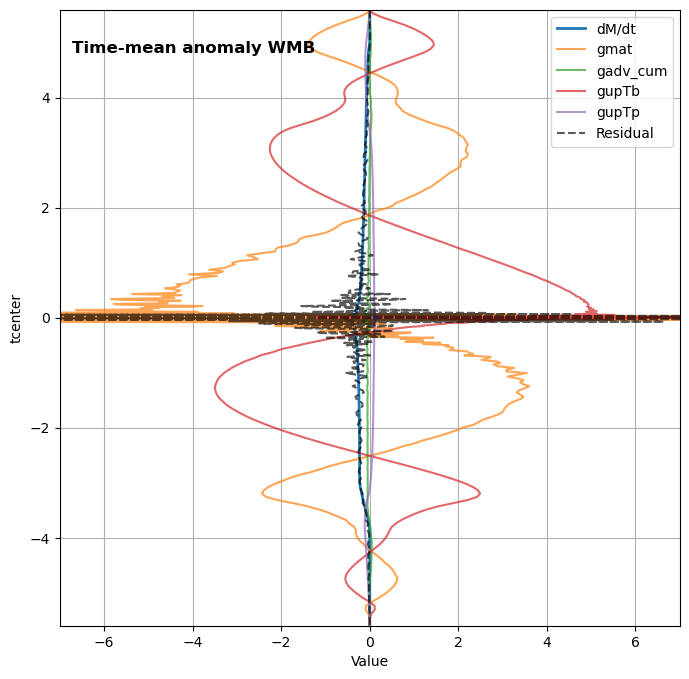

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Compute time-mean of each term along t dimension
M_trend_mean = M_trend.mean(dim='t')
gmat_mean = gmat.mean(dim='t')
gadv_cum_mean = gadv_cum.mean(dim='t')
gupTb_mean = gupTb.mean(dim='t')
gupTp_mean = gupTp.mean(dim='t')

# Compute time-mean residual
RHS_mean = gmat_mean + gadv_cum_mean + gupTb_mean + gupTp_mean
residual_mean = M_trend_mean - RHS_mean

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(8, 8))  # tall figure for vertical orientation

# Plot each term with tcenter on y-axis
ax.plot(M_trend_mean.values, M_trend.tcenter.values, label='dM/dt', linewidth=2)
ax.plot(gmat_mean.values, gmat.tcenter.values, label='gmat', alpha=0.7)
ax.plot(gadv_cum_mean.values, gadv_cum.tcenter.values, label='gadv_cum', alpha=0.7)
ax.plot(gupTb_mean.values, gupTb.tcenter.values, label='gupTb', alpha=0.7)
ax.plot(gupTp_mean.values, gupTp.tcenter.values, label='gupTp', alpha=0.7)
ax.plot(residual_mean.values, M_trend.tcenter.values, 'k--', label='Residual', linewidth=1.5,alpha=0.65)

# Labels, legend
ax.set_ylabel('tcenter')
ax.set_xlabel('Value')
ax.set_xlim(-7, 7)
ax.set_ylim(-5.6, 5.6)

ax.legend(loc='upper right')
ax.text(0.02, 0.95, 'Time-mean anomaly WMB', transform=ax.transAxes,
        fontsize=12, fontweight='bold', va='top', ha='left')
ax.grid(True)
plt.show()


# 100 bins of method quantitile

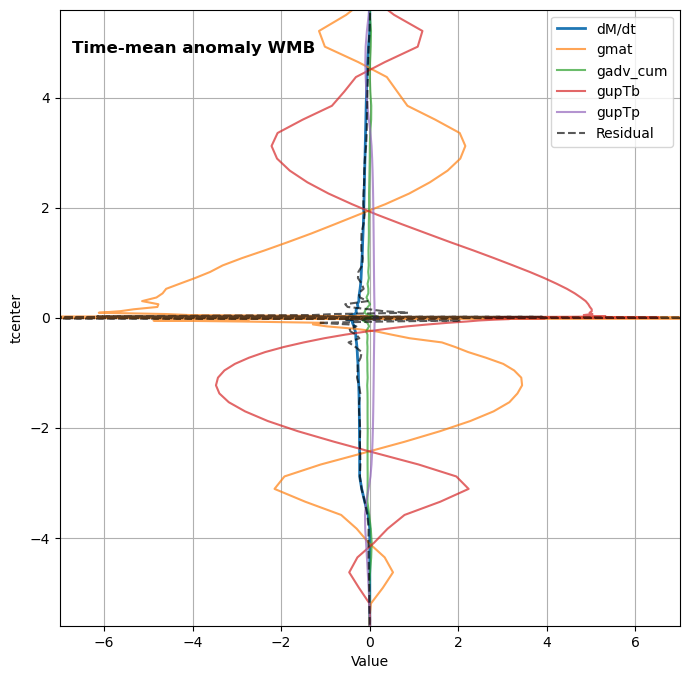

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Compute time-mean of each term along t dimension
M_trend_mean = M_trend.mean(dim='t')
gmat_mean = gmat.mean(dim='t')
gadv_cum_mean = gadv_cum.mean(dim='t')
gupTb_mean = gupTb.mean(dim='t')
gupTp_mean = gupTp.mean(dim='t')

# Compute time-mean residual
RHS_mean = gmat_mean + gadv_cum_mean + gupTb_mean + gupTp_mean
residual_mean = M_trend_mean - RHS_mean

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(8, 8))  # tall figure for vertical orientation

# Plot each term with tcenter on y-axis
ax.plot(M_trend_mean.values, M_trend.tcenter.values, label='dM/dt', linewidth=2)
ax.plot(gmat_mean.values, gmat.tcenter.values, label='gmat', alpha=0.7)
ax.plot(gadv_cum_mean.values, gadv_cum.tcenter.values, label='gadv_cum', alpha=0.7)
ax.plot(gupTb_mean.values, gupTb.tcenter.values, label='gupTb', alpha=0.7)
ax.plot(gupTp_mean.values, gupTp.tcenter.values, label='gupTp', alpha=0.7)
ax.plot(residual_mean.values, M_trend.tcenter.values, 'k--', label='Residual', linewidth=1.5,alpha=0.65)

# Labels, legend
ax.set_ylabel('tcenter')
ax.set_xlabel('Value')
ax.set_xlim(-7, 7)
ax.set_ylim(-5.6, 5.6)

ax.legend(loc='upper right')
ax.text(0.02, 0.95, 'Time-mean anomaly WMB', transform=ax.transAxes,
        fontsize=12, fontweight='bold', va='top', ha='left')
ax.grid(True)
plt.show()


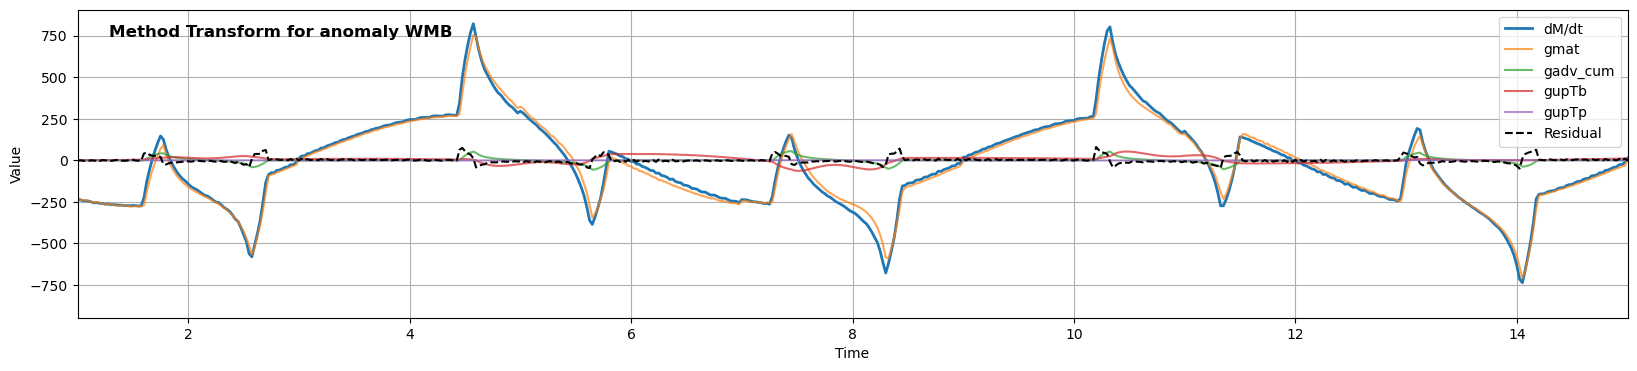

In [31]:
import matplotlib.pyplot as plt

# Select index
idx = 150

# Compute RHS and residual
RHS = gmat.isel(tcenter=idx).values + gadv_cum.isel(tcenter=idx).values + \
      gupTb.isel(tcenter=idx).values + gupTp.isel(tcenter=idx).values

residual = M_trend.isel(tcenter=idx).values - RHS[0:-1]

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(20, 4))

# Plot each component
ax.plot(M_trend.t.values, M_trend.isel(tcenter=idx).values, label='dM/dt', linewidth=2)
ax.plot(gmat.t.values, gmat.isel(tcenter=idx).values, label='gmat', alpha=0.7)
ax.plot(gadv_cum.t.values, gadv_cum.isel(tcenter=idx).values, label='gadv_cum', alpha=0.7)
ax.plot(gupTb.t.values, gupTb.isel(tcenter=idx).values, label='gupTb', alpha=0.7)
ax.plot(gupTp.t.values, gupTp.isel(tcenter=idx).values, label='gupTp', alpha=0.7)

# Plot residual
ax.plot(M_trend.t.values, residual, 'k--', label='Residual', linewidth=1.5)

# Legend and labels
ax.legend(loc='upper right')
ax.text(0.02, 0.95, 'Method Transform for anomaly WMB', transform=ax.transAxes,
        fontsize=12, fontweight='bold', va='top', ha='left')
ax.set_ylabel('Value')
ax.set_xlabel('Time')
ax.grid(True)
ax.set_xlim(1,15)
plt.show()


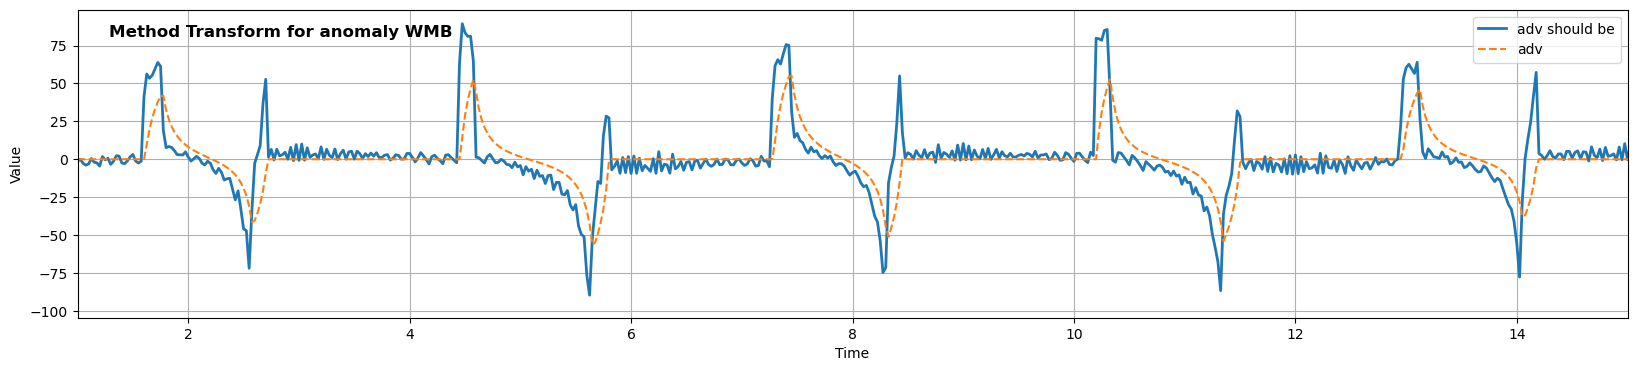

In [33]:
import matplotlib.pyplot as plt

# Select index
idx = 150

# Compute RHS and residual
RHS = gmat.isel(tcenter=idx).values + gadv_cum.isel(tcenter=idx).values + \
      gupTb.isel(tcenter=idx).values + gupTp.isel(tcenter=idx).values

residual = M_trend.isel(tcenter=idx).values - RHS[0:-1]

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(20, 4))

# Plot each component
ax.plot(M_trend.t.values, M_trend.isel(tcenter=idx).values - gmat.isel(tcenter=idx).values[0:-1] - gupTb.isel(tcenter=idx).values[0:-1] - gupTp.isel(tcenter=idx).values[0:-1], label='adv should be', linewidth=2)

# Plot residual
ax.plot(M_trend.t.values, gadv_cum.isel(tcenter=idx).values[0:-1], '--', label='adv', linewidth=1.5)

# Legend and labels
ax.legend(loc='upper right')
ax.text(0.02, 0.95, 'Method Transform for anomaly WMB', transform=ax.transAxes,
        fontsize=12, fontweight='bold', va='top', ha='left')
ax.set_ylabel('Value')
ax.set_xlabel('Time')
ax.grid(True)
ax.set_xlim(1,15)
plt.show()

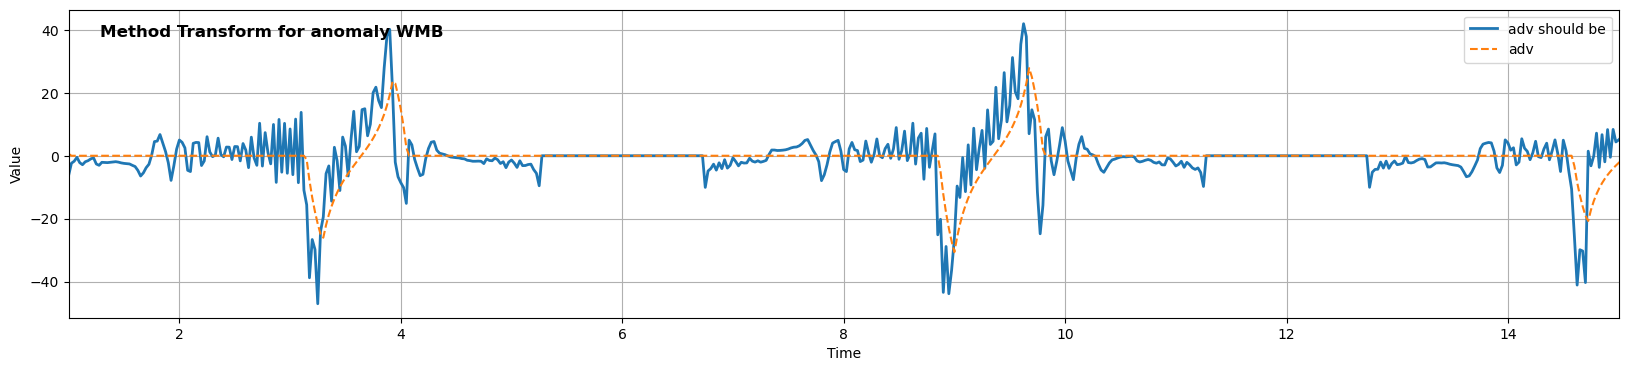

In [60]:
import matplotlib.pyplot as plt

# Select index
idx = 100

# Compute RHS and residual
RHS = gmat.isel(tcenter=idx).values + gadv_cum.isel(tcenter=idx).values + \
      gupTb.isel(tcenter=idx).values + gupTp.isel(tcenter=idx).values

residual = M_trend.isel(tcenter=idx).values - RHS[0:-1]

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(20, 4))

# Plot each component
ax.plot(M_trend.t.values, M_trend.isel(tcenter=idx).values - gmat.isel(tcenter=idx).values[0:-1] - gupTb.isel(tcenter=idx).values[0:-1] - gupTp.isel(tcenter=idx).values[0:-1], label='adv should be', linewidth=2)

# Plot residual
ax.plot(M_trend.t.values, gadv_cum.isel(tcenter=idx).values[0:-1], '--', label='adv', linewidth=1.5)

# Legend and labels
ax.legend(loc='upper right')
ax.text(0.02, 0.95, 'Method Transform for anomaly WMB', transform=ax.transAxes,
        fontsize=12, fontweight='bold', va='top', ha='left')
ax.set_ylabel('Value')
ax.set_xlabel('Time')
ax.grid(True)
ax.set_xlim(1,15)
plt.show()